## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=0
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import os                                                                       
import numpy as np                                                              
import tensorflow as tf                                                         
import data.data_selector as ds                                                   
import analysis.analysis_picker as ap
import utils.plot_functions as pf                                               

## Model parameters

In [3]:
class analysis_params(object):
  model_type = "lca_pca",
  model_name = "lca_pca",
  version = "0.0",
  save_info = "analysis"}

# Computed params
analysis_params.model_dir = (os.path.expanduser("~")+"/Work/Projects/"+analysis_params.model_name)

## Load analyzer

In [4]:
analyzer = ap.get_analyzer(analysis_params)
analyzer.model.setup(analyzer.model_params)
analyzer.load_analysis(save_info=analysis_params.save_info)

## Construct analysis plots

### Activity covariance matrix summaries

/home/dpaiton/tensorflow/lib/python3.4/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/home/dpaiton/tensorflow/lib/python3.4/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/home/dpaiton/tensorflow/lib/python3.4/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


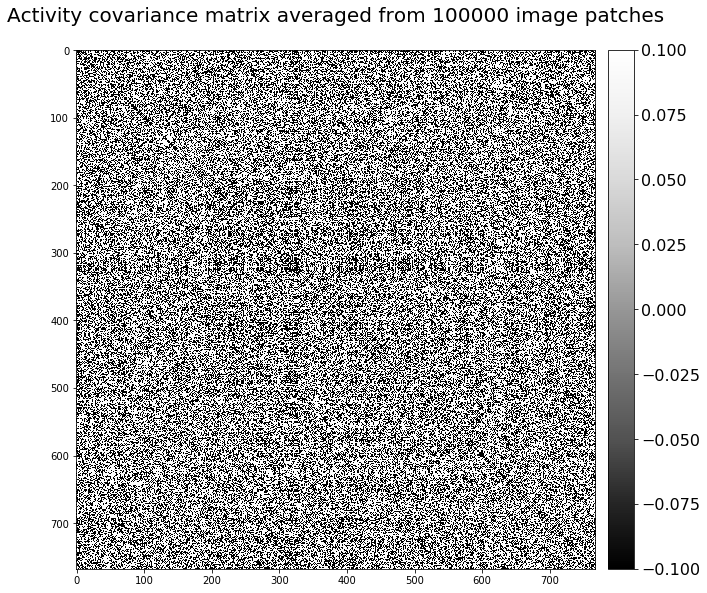

In [6]:
fig_title = "Activity covariance matrix averaged from "+str(analysis_params.cov_num_images)+" image patches\n"
fig = pf.plot_matrix(np.log(analyzer.act_cov), fig_title)
#fig = pf.plot_matrix(act_cov, fig_title)
fig.savefig(analyzer.analysis_out_dir+"vis/covariance_matrix.png")

/home/dpaiton/tensorflow/lib/python3.4/site-packages/matplotlib/axes/_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


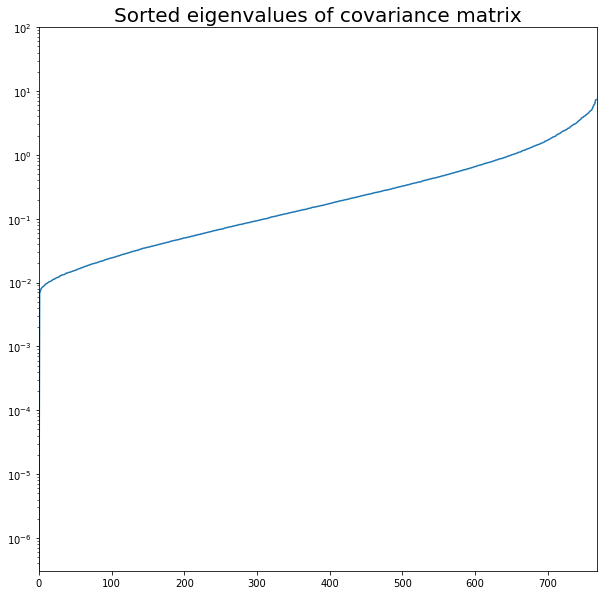

In [8]:
fig = pf.plot_eigenvalues(analyzer.a_eigvals, ylim=[0,100])
#fig = pf.plot_eigenvalues(a_eigvals, ylim=[0,100])
fig.savefig(analyzer.analysis_out_dir+"vis/eigenvalues.png")

/home/dpaiton/tensorflow/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


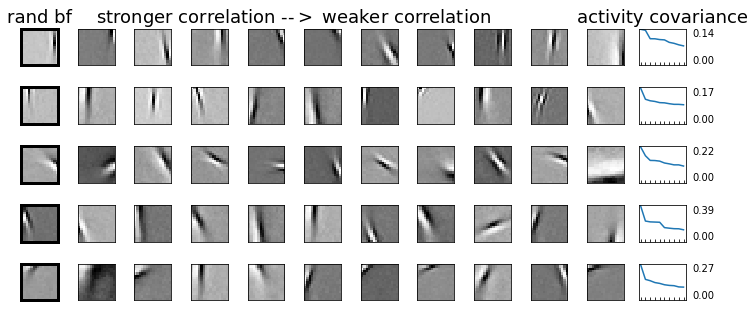

In [9]:
num_random_bases = 5
num_top_cov_bases = 10
bf_indices = np.random.choice(np.arange(analyzer.act_cov.shape[0]), num_random_bases)
fig = pf.plot_top_bases(analyzer.act_cov, analyzer.evals["weights/phi:0"],
  bf_indices, num_top_cov_bases)
fig.savefig(analyzer.analysis_out_dir+"vis/top_cov_bases.png")

### Basis function analysis

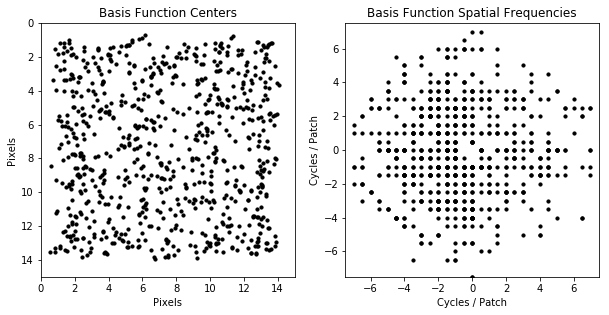

In [11]:
fig = pf.plot_loc_freq_summary(analyzer.bf_stats)
fig.savefig(analyzer.analysis_out_dir+"vis/location_frequency_centers.png")

### Pooling and eigen summary plots

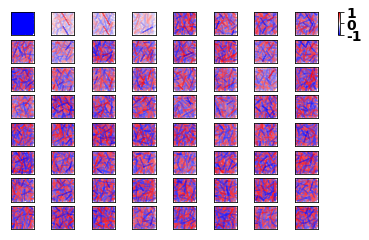

In [15]:
num_pooling_filters = 64 # How many 2nd layer filters to display
num_connected_weights = analyzer.model.num_neurons # How many of strongest connected weight summaries to show
fig = pf.plot_pooling_summaries(analyzer.bf_stats, analyzer.a_eigvecs,
  num_pooling_filters, num_connected_weights, lines=True)
fig.savefig(analyzer.analysis_out_dir+"vis/eigen_pooling_lines.png")

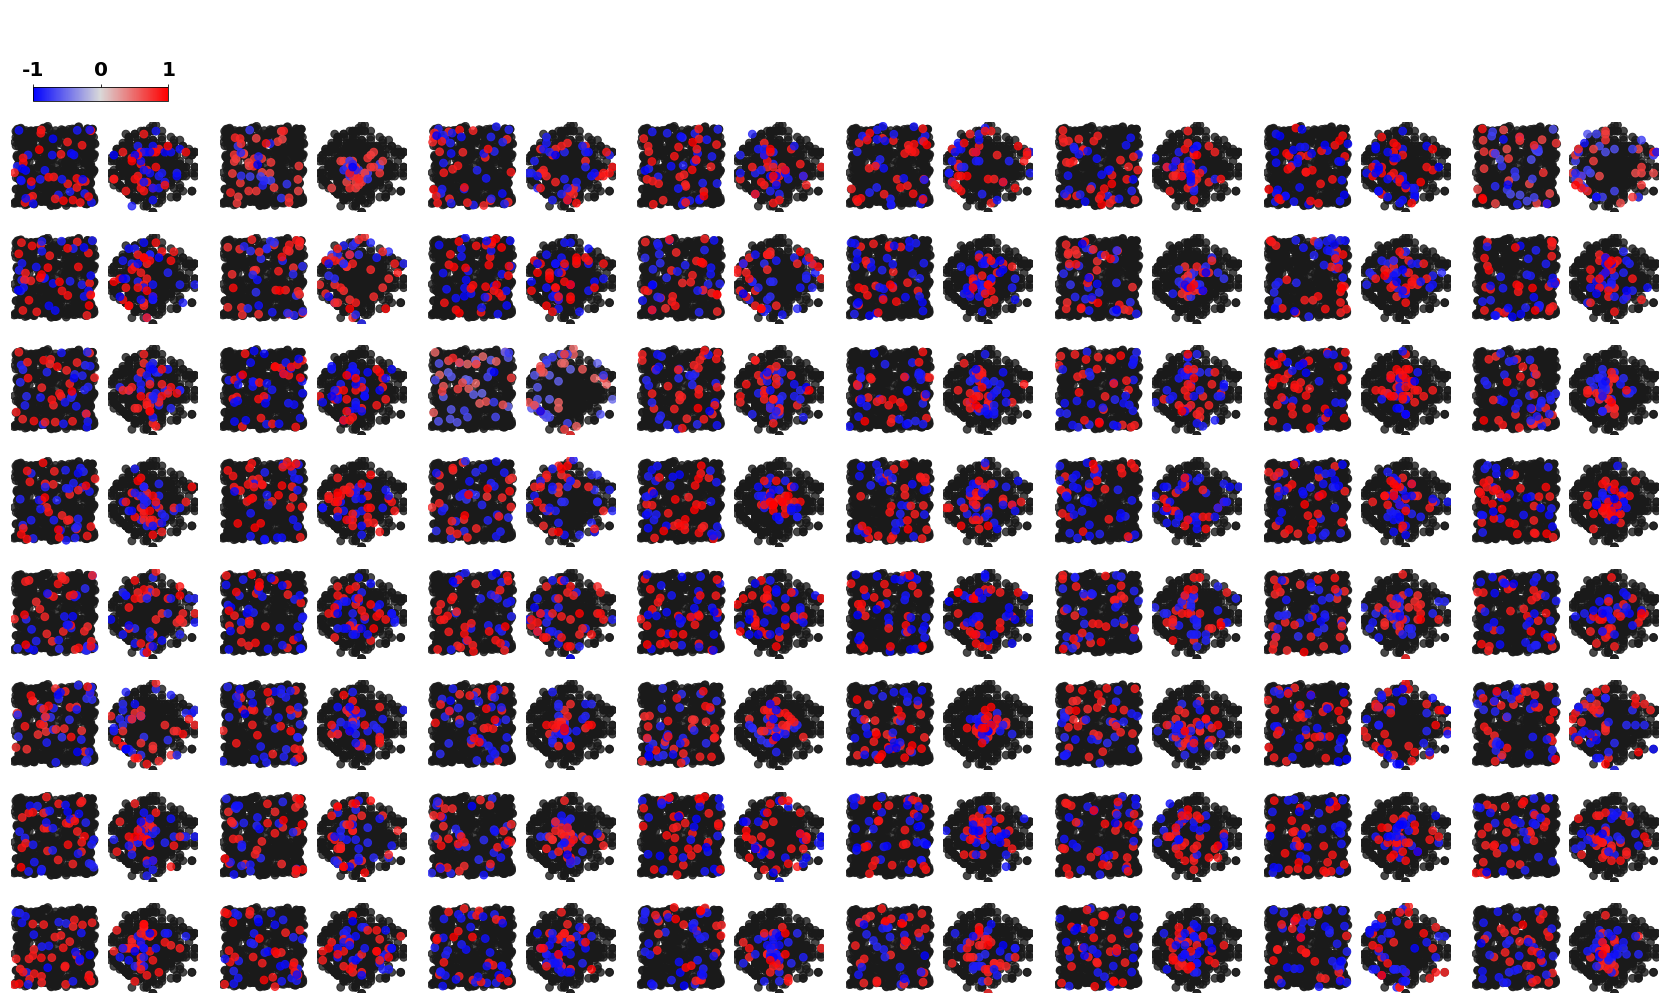

In [16]:
num_pooling_filters = 64
num_connected_weights = 50
filter_indices = None
fig_size = (10, 10)
spot_size = 60
fig = pf.plot_pooling_centers(analyzer.bf_stats, analyzer.a_eigvecs, num_pooling_filters,
  num_connected_weights, filter_indices, spot_size, figsize=fig_size)
fig.savefig(analyzer.analysis_out_dir+"vis/eigen_pooling_centers.png", bbox_inches="tight")

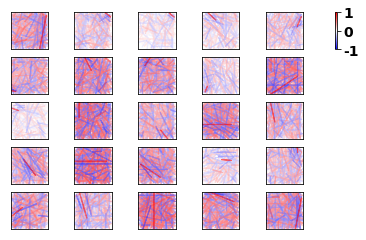

In [8]:
num_pooling_filters = 25
num_connected_weights = analyzer.model.num_neurons
fig = pf.plot_pooling_summaries(analyzer.bf_stats, analyzer.pooling_filters, num_pooling_filters,
  num_connected_weights, lines=True)
fig.savefig(analyzer.analysis_out_dir+"vis/pooling_lines.png")

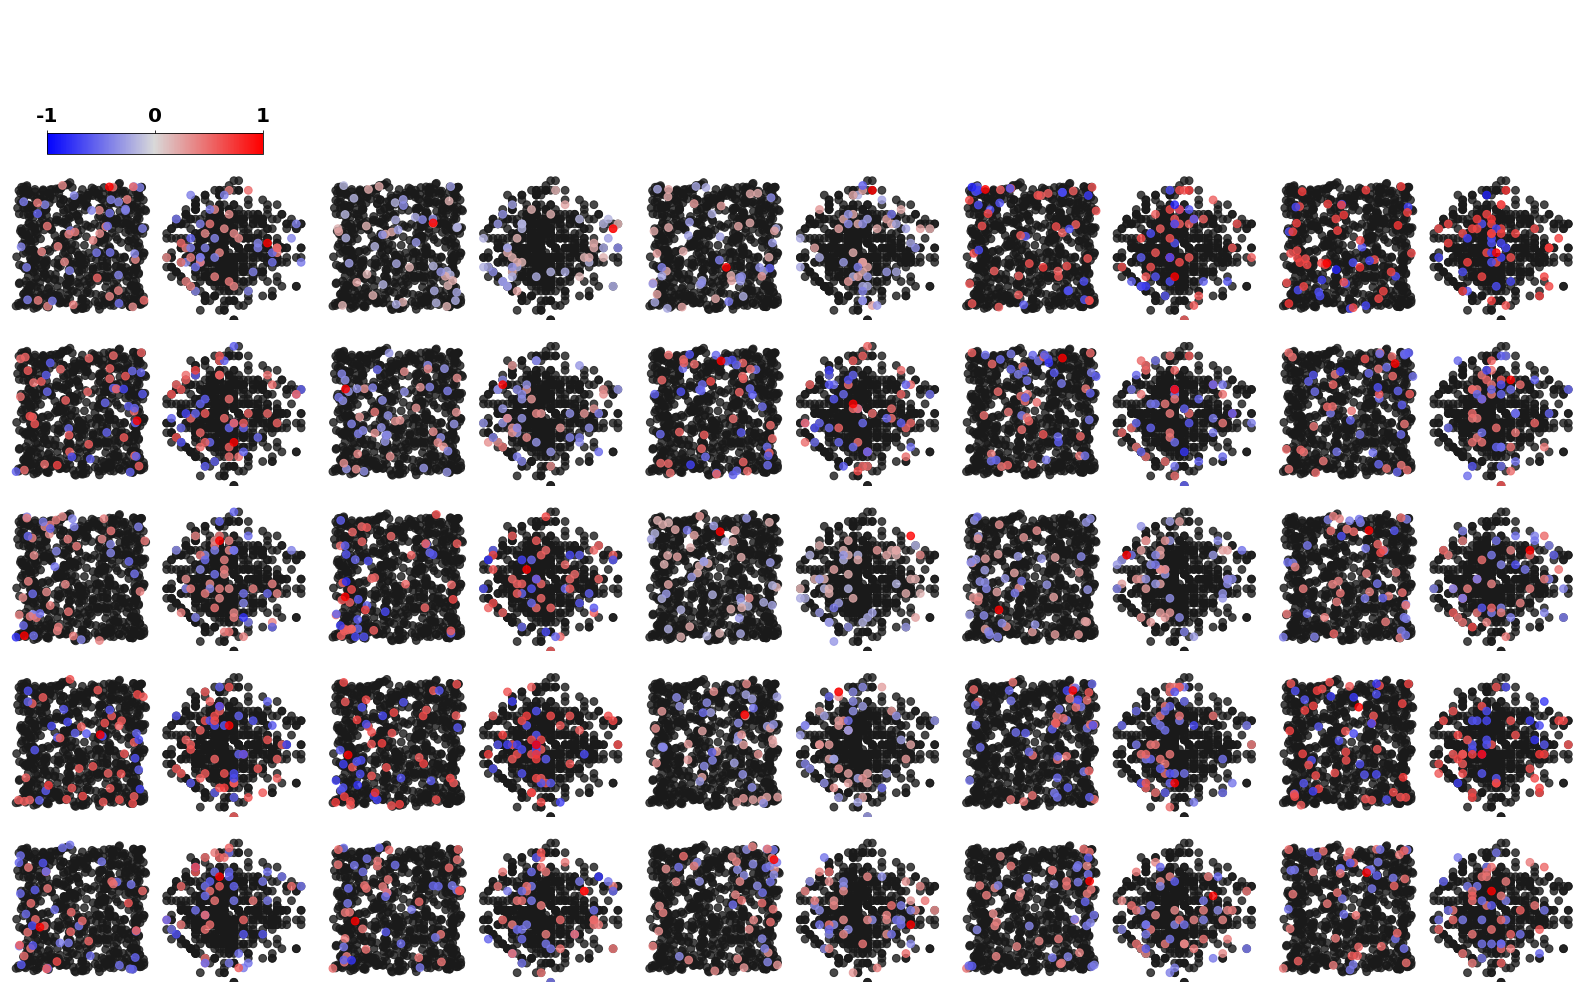

In [219]:
num_pooling_filters = 25
num_connected_weights = 50
filter_indices = np.arange(50,75)#None
fig_size = (10, 10)
spot_size = 60
fig = pf.plot_pooling_centers(analyzer.bf_stats, analyzer.pooling_filters, num_pooling_filters,
  num_connected_weights, filter_indices, spot_size, figsize=fig_size)
fig.savefig(analyzer.analysis_out_dir+"vis/pooling_centers.png", bbox_inches="tight")

In [10]:
import matplotlib.pyplot as plt
import matplotlib
def plot_pooling_centers(bf_stats, pooling_filters, num_pooling_filters, num_connected_weights,
  spot_size=10, figsize=None):
  """
  Plot 2nd layer (fully-connected) weights in terms of spatial/frequency centers of
    1st layer weights
  Inputs:
    bf_stats [dict] Output of dp.get_dictionary_stats() which was run on the 1st layer weights
    pooling_filters [np.ndarray] 2nd layer weights
      should be shape [num_1st_layer_neurons, num_2nd_layer_neurons]
    num_pooling_filters [int] How many 2nd layer neurons to plot
    figsize [tuple] Containing the (width, height) of the figure, in inches
    spot_size [int] How big to make the points
  """
  num_filters_y = int(np.ceil(np.sqrt(num_pooling_filters)))
  num_filters_x = int(np.ceil(np.sqrt(num_pooling_filters)))
  tot_pooling_filters = pooling_filters.shape[1]
  #filter_indices = np.random.choice(tot_pooling_filters, num_pooling_filters, replace=False)
  filter_indices = np.arange(tot_pooling_filters, dtype=np.int32)
  cmap = plt.get_cmap(pf.bgr_colormap())# Could also use "nipy_spectral", "coolwarm", "bwr"
  cNorm = matplotlib.colors.SymLogNorm(linthresh=0.03, linscale=0.01, vmin=-1.0, vmax=1.0)
  scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cmap)
  x_p_cent = [x for (y,x) in bf_stats["gauss_centers"]]# Get raw points
  y_p_cent = [y for (y,x) in bf_stats["gauss_centers"]]
  x_f_cent = [x for (y,x) in bf_stats["fourier_centers"]]
  y_f_cent = [y for (y,x) in bf_stats["fourier_centers"]]
  max_sf = np.max(np.abs(x_f_cent+y_f_cent))
  pair_w_gap = 0.01
  group_w_gap = 0.03
  h_gap = 0.03
  plt_w = (num_filters_x/num_pooling_filters)
  plt_h = plt_w
  if figsize is None:
    fig = plt.figure()
  else:
    fig = plt.figure(figsize=figsize) #figsize is (w,h)
  axes = []
  filter_id = 0
  for plot_id in np.ndindex((num_filters_y, num_filters_x)):
    if all(pid == 0 for pid in plot_id):
      axes.append(pf.clear_axis(fig.add_axes([0, plt_h+h_gap, 2*plt_w, plt_h])))
      scalarMap._A = []
      cbar = fig.colorbar(scalarMap, ax=axes[-1], ticks=[-1, 0, 1], aspect=10, location="bottom")
      cbar.ax.set_xticklabels(["-1", "0", "1"])
      cbar.ax.xaxis.set_ticks_position('top')
      cbar.ax.xaxis.set_label_position('top')
      for label in cbar.ax.xaxis.get_ticklabels():
        label.set_weight("bold")
        label.set_fontsize(10+figsize[0])
    if (filter_id < num_pooling_filters):
      example_filter = pooling_filters[:, filter_indices[filter_id]]
      top_indices = np.argsort(np.abs(example_filter))[::-1] #descending
      selected_indices = top_indices[:num_connected_weights][::-1] #select top, plot weakest first
      filter_norm = np.max(np.abs(example_filter))
      connection_colors = [scalarMap.to_rgba(example_filter[bf_idx]/filter_norm)
        for bf_idx in range(bf_stats["num_outputs"])]
      if num_connected_weights < top_indices.size:
        black_indices = top_indices[num_connected_weights:][::-1]
        xp = [x_p_cent[i] for i in black_indices]+[x_p_cent[i] for i in selected_indices]
        yp = [y_p_cent[i] for i in black_indices]+[y_p_cent[i] for i in selected_indices]
        xf = [x_f_cent[i] for i in black_indices]+[x_f_cent[i] for i in selected_indices]
        yf = [y_f_cent[i] for i in black_indices]+[y_f_cent[i] for i in selected_indices]
        c = [(0.1,0.1,0.1,1.0) for i in black_indices]+[connection_colors[i] for i in selected_indices]
      else:
        xp = [x_p_cent[i] for i in selected_indices]
        yp = [y_p_cent[i] for i in selected_indices]
        xf = [x_f_cent[i] for i in selected_indices]
        yf = [y_f_cent[i] for i in selected_indices]
        c = [connection_colors[i] for i in selected_indices]
      (y_id, x_id) = plot_id
      if x_id == 0:
        ax_l = 0
        ax_b = - y_id * (plt_h+h_gap)
      else:
        bbox = axes[-1].get_position().get_points()[0]#bbox is [[x0,y0],[x1,y1]]
        prev_l = bbox[0]
        prev_b = bbox[1]
        ax_l = prev_l + plt_w + group_w_gap
        ax_b = prev_b
      ax_w = plt_w
      ax_h = plt_h
      axes.append(pf.clear_axis(fig.add_axes([ax_l, ax_b, ax_w, ax_h])))
      axes[-1].invert_yaxis()
      axes[-1].scatter(xp, yp, c=c, s=spot_size, alpha=0.8)
      axes[-1].set_xlim(0, bf_stats["patch_edge_size"]-1)
      axes[-1].set_ylim(bf_stats["patch_edge_size"]-1, 0)
      axes[-1].set_aspect("equal")
      axes[-1].set_facecolor("w")
      axes.append(pf.clear_axis(fig.add_axes([ax_l+ax_w+pair_w_gap, ax_b, ax_w, ax_h])))
      axes[-1].scatter(xf, yf, c=c, s=spot_size, alpha=0.8)
      axes[-1].set_xlim([-max_sf, max_sf])
      axes[-1].set_ylim([-max_sf, max_sf])
      axes[-1].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
      axes[-1].yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
      axes[-1].set_aspect("equal")
      axes[-1].set_facecolor("w")
      #histogram - note: axis widths/heights are not setup for a third plot
      #axes.append(fig.add_axes([ax_l+ax_w+pair_w_gap, ax_b, ax_w, ax_h]))
      #axes[-1].set_yticklabels([])
      #axes[-1].tick_params(axis="y", bottom="off", top="off", left="off", right="off")
      #axes[-1].hist([example_filter[bf_idx]/filter_norm for bf_idx in range(bf_stats["num_outputs"])])
      filter_id += 1
  plt.show()
  return fig

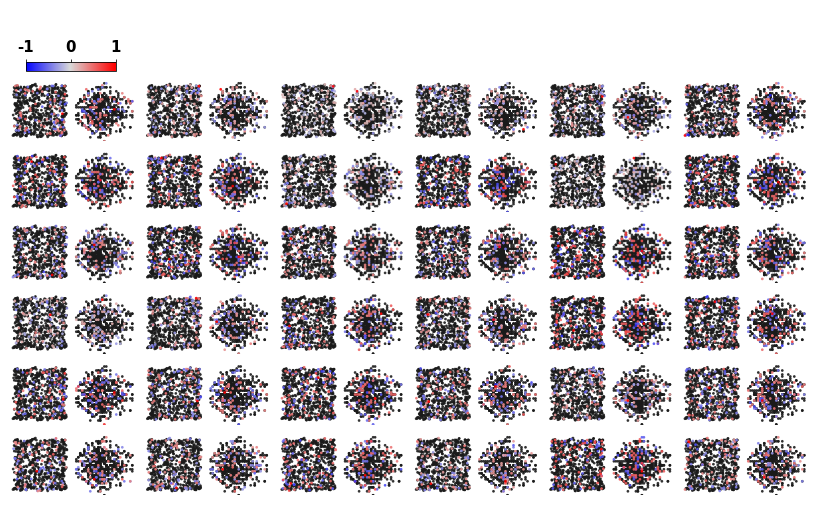

In [11]:
fig = plot_pooling_centers(analyzer.bf_stats, analyzer.pooling_filters, num_pooling_filters=36, num_connected_weights=100, spot_size=3, figsize=(5,5))
fig.savefig(analyzer.analysis_out_dir+"vis/pooling_spots.png", transparent=True, bbox_inches="tight")

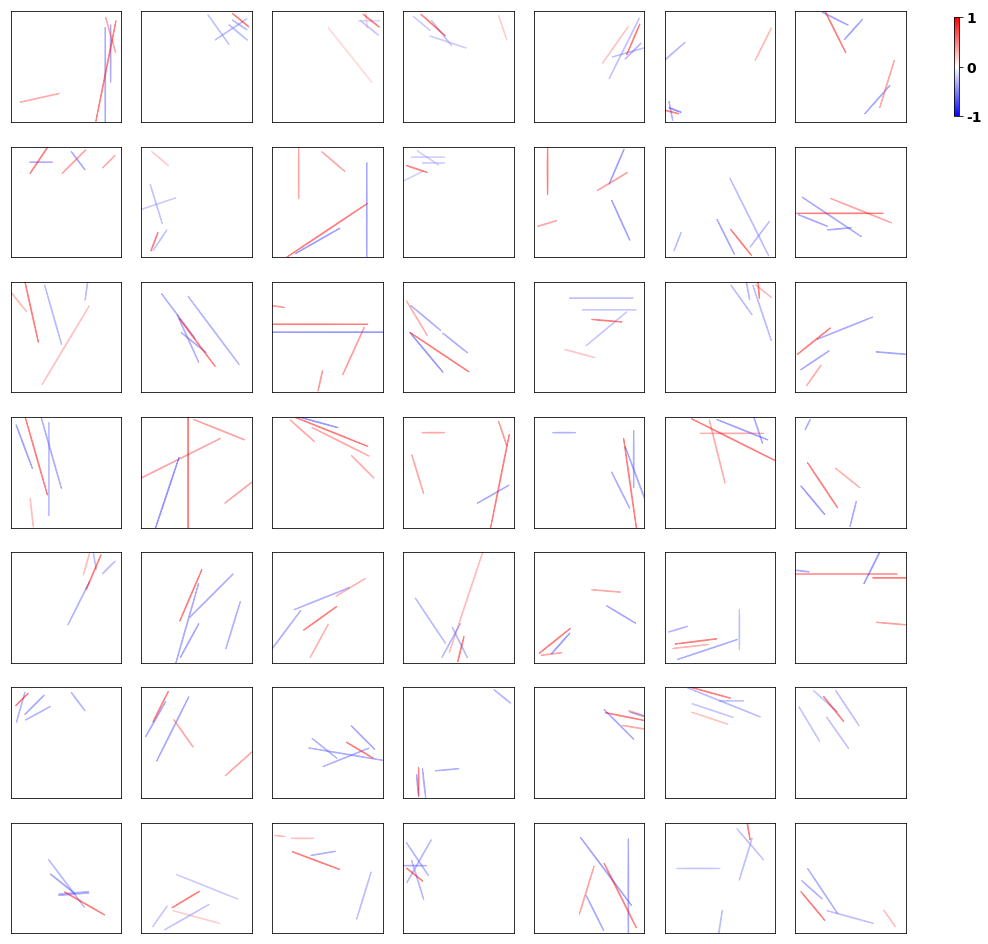

In [91]:
fig = pf.plot_pooling_summaries(analyzer.bf_stats, analyzer.pooling_filters, num_pooling_filters=49, num_connected_weights=5, lines=True, figsize=(18,18))
fig.savefig(analyzer.analysis_out_dir+"vis/few_pooling_lines.png", transparent=True, bbox_inches="tight")

In [165]:
neuron_angles = analyzer.neuron_angles(analyzer.bf_stats) * (180/np.pi)

BF indices = [ 11 ,  110 ]


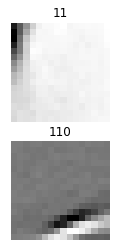

vector angle	=  90.44351400804378  rad
		=  5182.031636993249  deg
bf1 norm =  1.0
bf2 norm =  1.0


In [256]:
pooling_filter_id = 54
input_id0 = 0
input_id1 = 1
num_cov_indices = np.max([input_id0, input_id1])+1
sorted_cov_indices = np.argsort(analyzer.act_cov[pooling_filter_id, :])[-2::-1]
sorted_base_indices = sorted_cov_indices[:num_cov_indices]
bf_id0 = sorted_base_indices[input_id0]
bf_id1 = orthog_idx#sorted_base_indices[input_id1]#orthog_idx
print("BF indices = [",bf_id0,", ",bf_id1,"]")
fig, ax = plt.subplots(2)
ax[0] = pf.clear_axis(ax[0])
ax[0].imshow(analyzer.bf_stats["basis_functions"][bf_id0], cmap="Greys_r")
ax[0].set_title(str(bf_id0))
ax[1] = pf.clear_axis(ax[1])
ax[1].imshow(analyzer.bf_stats["basis_functions"][bf_id1], cmap="Greys_r")
ax[1].set_title(str(bf_id1))
plt.show()
print("vector angle\t= ", neuron_angles[bf_id0, bf_id1], " rad\n\t\t= ", neuron_angles[bf_id0, bf_id1]*(180/np.pi), " deg")
bf1 = analyzer.bf_stats["basis_functions"][bf_id0].reshape((analyzer.model_params.patch_edge_size**2))
bf2 = analyzer.bf_stats["basis_functions"][bf_id1].reshape((analyzer.model_params.patch_edge_size**2))
bf1_norm = np.linalg.norm(bf1)
bf2_norm = np.linalg.norm(bf2)
print("bf1 norm = ", bf1_norm)
print("bf2 norm = ", bf2_norm)
bf1 /= bf1_norm
bf2 /= bf2_norm

In [257]:
import utils.data_processing as dp
from data.dataset import Dataset
num_imgs = 10000

x_pts = np.linspace(-2.0, 2.0, int(np.sqrt(num_imgs)))
y_pts = np.linspace(-2.0, 2.0, int(np.sqrt(num_imgs)))
X, Y = np.meshgrid(x_pts, y_pts)
proj_datapoints = np.stack([X.reshape(num_imgs), Y.reshape(num_imgs)], axis=1)

proj_matrix, proj_v = analyzer.bf_projections(bf1, bf2)
proj_neuron1 = np.dot(proj_matrix, bf1).T
proj_neuron2 = np.dot(proj_matrix, bf2).T

datapoints = np.stack([np.dot(proj_matrix.T, proj_datapoints[data_id,:]) for data_id in range(num_imgs)]) #inject
datapoints, orig_shape = dp.reshape_data(datapoints, flatten=False)[:2]
datapoints = {"test": Dataset(datapoints, lbls=None, ignore_lbls=None, rand_state=analyzer.rand_state)}
datapoints = analyzer.model.preprocess_dataset(datapoints,
  params={"whiten_data":analyzer.model_params.whiten_data,
  "whiten_method":analyzer.model_params.whiten_method})
datapoints = analyzer.model.reshape_dataset(datapoints, analyzer.model_params)
datapoints["test"].images /= np.max(np.abs(datapoints["test"].images))
datapoints["test"].images *= analyzer.analysis_params["input_scale"]

In [258]:
activations = analyzer.compute_pooled_activations(datapoints["test"].images, analyzer.act_cov)
activity_max = np.amax(np.abs(activations))
norm_activity = activations / (activity_max+0.0001)

INFO:tensorflow:Restoring parameters from /home/dpaiton/Work/Projects/lca_pca/checkpoints/lca_pca_v0.0_weights-100000


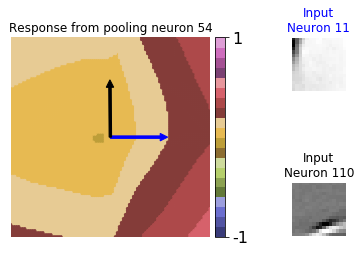

In [259]:
import matplotlib.gridspec as gridspec
#def plot_iso_response_contours(cmap, save_filename)
num_plots_y = 1
num_plots_x = 2
gs1 = gridspec.GridSpec(num_plots_y, num_plots_x, wspace=0.5, width_ratios=[4, 1])
fig = plt.figure(figsize=(6, 6))
curve_ax = pf.clear_axis(fig.add_subplot(gs1[0]))
cmap = plt.get_cmap('tab20b')
#cmap = plt.get_cmap('viridis')
#cmap = plt.get_cmap('jet')
vmin = np.floor(np.min(norm_activity))#0.0
vmax = np.ceil(np.max(norm_activity))#1.0
rank_indices = np.argsort(norm_activity[:, bf_id0])

pts = curve_ax.scatter(proj_datapoints[:,0][rank_indices], proj_datapoints[:,1][rank_indices],
  vmin=vmin, vmax=vmax, cmap=cmap, c=norm_activity[:, bf_id0][rank_indices], s=5.0)
curve_ax.arrow(0, 0, proj_neuron1[0].item(), proj_neuron1[1].item(), width=0.05, head_width=0.15,
  head_length=0.15, fc='b', ec='b')
curve_ax.arrow(0, 0, proj_neuron2[0].item(), proj_neuron2[1].item(), width=0.05, head_width=0.15,
  head_length=0.15, fc='k', ec='k')
#curve_ax.set_title("Angle = "+"{:.2f}".format(neuron_angles[bf_id0, bf_id1])+" deg")
curve_ax.set_title("Response from pooling neuron "+"{:.0f}".format(pooling_filter_id))
curve_ax.set_ylim([-2, 2.0])
curve_ax.set_xlim([-2, 2.0])
curve_ax.set_aspect("equal")
cbar = pf.add_colorbar_to_im(pts, aspect=20, pad_fraction=0.5, labelsize=16, ticks=[vmin, vmax])
cbar.ax.set_yticklabels(["{:.0f}".format(vmin), "{:.0f}".format(vmax)])

gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, gs1[1], wspace=2, hspace=-0.2)
bf1_ax = pf.clear_axis(fig.add_subplot(gs2[0]))
bf1_ax.imshow(analyzer.bf_stats["basis_functions"][bf_id0], cmap="Greys_r")
bf1_ax.set_title("Input\nNeuron {:.0f}".format(bf_id0), color='b')
bf2_ax = pf.clear_axis(fig.add_subplot(gs2[1]))
bf2_ax.imshow(analyzer.bf_stats["basis_functions"][bf_id1], cmap="Greys_r")
bf2_ax.set_title("Input\nNeuron {:.0f}".format(bf_id1), color='k')
fig.savefig(analyzer.analysis_out_dir+"/vis/l2_neuron_response_contours_pid"+str(pooling_filter_id)+"_bf0id"+str(bf_id0)+"_bf1id"+str(bf_id1)+".png")
plt.show()

In [224]:
x_target = x_pts[int(6*np.sqrt(num_imgs)/8)] # find a location to take a slice
slice_indices = np.where(proj_datapoints[:,0]==x_target)[0]
x_vals = proj_datapoints[slice_indices,:][:,1] # slice grid

In [264]:
pop_num_imgs = 100

orthogonal_list = [idx for idx in range(analyzer.bf_stats["num_outputs"]) if idx != bf_id0]#[bf_id1]
num_orthogonal = len(orthogonal_list)

pop_x_pts = np.linspace(-2.0, 2.0, int(pop_num_imgs))
pop_y_pts = np.linspace(-2.0, 2.0, int(pop_num_imgs))
pop_X, pop_Y = np.meshgrid(pop_x_pts, pop_y_pts)
pop_proj_datapoints = np.stack([pop_X.reshape(pop_num_imgs**2), pop_Y.reshape(pop_num_imgs**2)], axis=1) # construct a grid
x_target = pop_x_pts[int(6*pop_num_imgs/8)] # find a location to take a slice
slice_indices = np.where(pop_proj_datapoints[:,0]==x_target)[0]
pop_proj_datapoints = pop_proj_datapoints[slice_indices,:] # slice grid

pop_datapoints = [None,]*num_orthogonal
pop_proj_neurons = [None,]*num_orthogonal
for pop_idx, tmp_bf_id1 in enumerate(orthogonal_list):
  tmp_bf2 = analyzer.bf_stats["basis_functions"][tmp_bf_id1].reshape((analyzer.model_params.patch_edge_size**2))
  tmp_bf2 /= np.linalg.norm(tmp_bf2)
  tmp_proj_matrix, tmp_proj_v = analyzer.bf_projections(bf1, tmp_bf2) 
  pop_proj_neurons[pop_idx] = (np.dot(tmp_proj_matrix, bf1).T, np.dot(tmp_proj_matrix, tmp_bf2).T)
  pop_datapoints[pop_idx] = np.dot(pop_proj_datapoints, tmp_proj_matrix)#[slice_indices,:]

pop_datapoints = np.reshape(np.stack(pop_datapoints, axis=0),
  [num_orthogonal*pop_num_imgs, analyzer.model_params.patch_edge_size**2])

pop_datapoints = dp.reshape_data(pop_datapoints, flatten=False)[0]
pop_datapoints = {"test": Dataset(pop_datapoints, lbls=None, ignore_lbls=None, rand_state=analyzer.rand_state)}
pop_datapoints = analyzer.model.preprocess_dataset(pop_datapoints,
  params={"whiten_data":analyzer.model_params.whiten_data,
  "whiten_method":analyzer.model_params.whiten_method})
pop_datapoints = analyzer.model.reshape_dataset(pop_datapoints, analyzer.model_params)
pop_datapoints["test"].images /= np.max(np.abs(pop_datapoints["test"].images))
pop_datapoints["test"].images *= analyzer.analysis_params.input_scale

In [265]:
pop_activations = analyzer.compute_pooled_activations(pop_datapoints["test"].images, analyzer.act_cov)
pop_activations = pop_activations.reshape([num_orthogonal, pop_num_imgs, analyzer.model.num_neurons])[:,:,pooling_filter_id]
pop_norm_activity = pop_activations / np.amax(np.abs(pop_activations))

INFO:tensorflow:Restoring parameters from /home/dpaiton/Work/Projects/lca_pca/checkpoints/lca_pca_v0.0_weights-100000


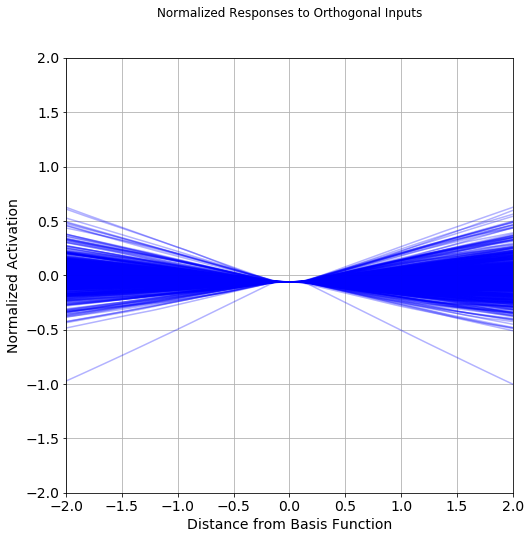

In [266]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
for orthog_idx in range(num_orthogonal):
 ax.plot(pop_proj_datapoints[:,1], pop_norm_activity[orthog_idx, :], color='b', alpha=0.3)
ax.set_title("Normalized Responses to Orthogonal Inputs", y=1.08)
ax.set_ylabel("Normalized Activation", fontsize=14)
ax.set_xlabel("Distance from Basis Function", fontsize=14)
ax.grid(True)
ax.set_ylim([-2.0, 2.0])
ax.set_xlim([np.min(x_vals), np.max(x_vals)])
#ax.set_aspect((np.max(x_vals)-np.min(x_vals)))#/(np.max(pop_norm_activity)-np.min(pop_norm_activity)))
ax.tick_params(labelsize=14)
fig.savefig(analyzer.analysis_out_dir+"/vis/l2_bf_curvatures_pid"+str(pooling_filter_id)+"_bf0id"+str(bf_id0)+"_bf1id"+str(bf_id1)+".png")
plt.show()

In [228]:
coeffs = [np.polynomial.polynomial.polyfit(pop_proj_datapoints[:,1], pop_norm_activity[orthog_idx,:], deg=2)
  for orthog_idx in range(num_orthogonal)]
fits = [np.polynomial.polynomial.polyval(pop_proj_datapoints[:,1], coeff) for coeff in coeffs]
curvatures = [np.polyder(fit, m=2) for fit in fits]

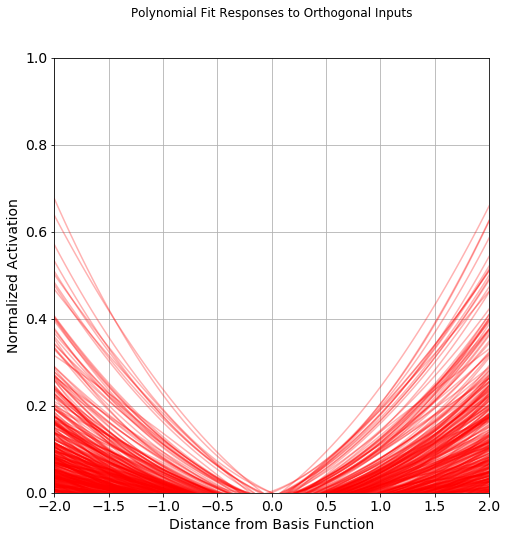

In [229]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
for orthog_idx in range(num_orthogonal):
  ax.plot(pop_proj_datapoints[:,1], fits[orthog_idx], color='r', alpha=0.3)
ax.set_title("Polynomial Fit Responses to Orthogonal Inputs", y=1.08)
ax.set_ylabel("Normalized Activation", fontsize=14)
ax.set_xlabel("Distance from Basis Function", fontsize=14)
ax.grid(True)
ax.set_ylim([0.0,1.0])
ax.set_xlim([np.min(pop_proj_datapoints[:,1]), np.max(pop_proj_datapoints[:,1])])
ax.set_aspect((np.max(pop_proj_datapoints[:,1])-np.min(pop_proj_datapoints[:,1])))
ax.tick_params(labelsize=14)
fig.savefig(analyzer.analysis_out_dir+"/vis/l2_fit_curvatures_pid"+str(pooling_filter_id)+"_bf0id"+str(bf_id0)+"_bf1id"+str(bf_id1)+".png")
plt.show()

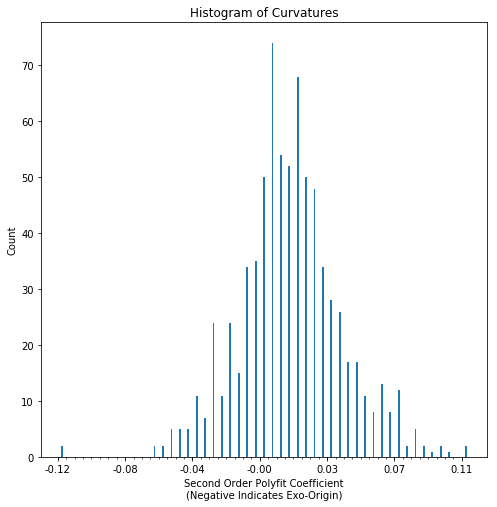

In [230]:
from matplotlib.ticker import FormatStrFormatter

curvatures = np.stack(coeffs, axis=0)[:,2]

num_bins = 50
bins = np.linspace(np.amin(curvatures), np.amax(curvatures), num_bins)
hist, bin_edges = np.histogram(curvatures.flatten(), bins)
bin_left, bin_right = bin_edges[:-1], bin_edges[1:]
bin_centers = bin_left + (bin_right - bin_left)/2

fig, ax = plt.subplots(1, figsize=(8,8))
ax.bar(bin_centers, hist, width=0.001, log=False, align="center")
ax.set_xticks(bin_left, minor=True)
ax.set_xticks(bin_left[::8], minor=False)
ax.xaxis.set_major_formatter(FormatStrFormatter("%0.2f"))

ax.set_title("Histogram of Curvatures")
ax.set_xlabel("Second Order Polyfit Coefficient\n(Negative Indicates Exo-Origin)")
ax.set_ylabel("Count")
fig.savefig(analyzer.analysis_out_dir+"/vis/l2_histogram_of_curvatures_pid"+str(pooling_filter_id)+"_bf0id"+str(bf_id0)+"_bf1id"+str(bf_id1)+".png")
plt.show()

In [231]:
concavity = np.asarray([np.sign(coeffs[idx][2]) for idx in range(len(coeffs))])
num_endo = np.sum(concavity>0)
endo_indices = np.argwhere(concavity>0)
num_exo = np.sum(concavity<0)
exo_indices = np.argwhere(concavity<0)
print("num >0 (tolerant/invariant/endo-origin):", num_endo,
  "\nnum <0 (selective/equivariant/exo-origin):", num_exo)

num >0 (tolerant/invariant/endo-origin): 543 
num <0 (selective/equivariant/exo-origin): 224


In [232]:
low = np.argwhere(curvatures>0.08)
high = np.argwhere(curvatures<0.09)
np.intersect1d(list(low), list(high))

array([110, 161, 227, 311, 350, 514, 577])

In [254]:
orthog_idx = 110
curvatures[orthog_idx]

0.0822918474998177

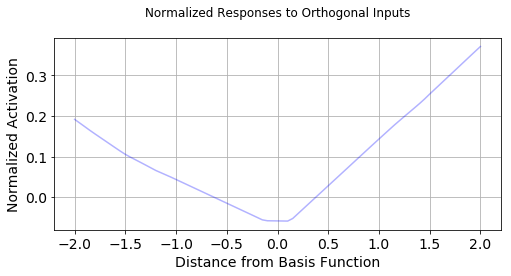

In [255]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.plot(pop_proj_datapoints[:,1], pop_norm_activity[orthog_idx, :], color='b', alpha=0.3)
ax.set_title("Normalized Responses to Orthogonal Inputs", y=1.08)
ax.set_ylabel("Normalized Activation", fontsize=14)
ax.set_xlabel("Distance from Basis Function", fontsize=14)
ax.grid(True)
#ax.set_ylim([0.0, 1.0])
#ax.set_xlim([np.min(x_vals), np.max(x_vals)])
ax.set_aspect((np.max(x_vals)-np.min(x_vals)))#/(np.max(pop_norm_activity)-np.min(pop_norm_activity)))
ax.tick_params(labelsize=14)
plt.show()

TypeError: only integer scalar arrays can be converted to a scalar index

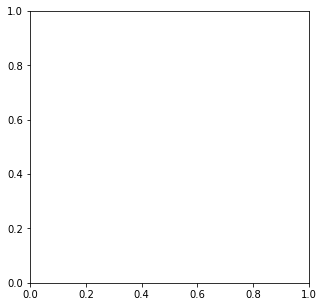

In [178]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for idx in endo_indices:
  ax.plot(pop_proj_datapoints[:,1], fits[idx], color="g", alpha=0.3)
ax.set_title("Normalized Responses to Invariant Inputs")
ax.set_ylabel("Normalized Activation", fontsize=14)
ax.set_xlabel("Distance from Basis Function", fontsize=14)
ax.grid(True)
ax.set_ylim([0.0,1.0])
ax.set_xlim([np.min(pop_proj_datapoints[:,1]), np.max(pop_proj_datapoints[:,1])])
ax.set_aspect((np.max(pop_proj_datapoints[:,1])-np.min(pop_proj_datapoints[:,1])))
ax.tick_params(labelsize=14)
fig.savefig(analyzer.analysis_out_dir+"/vis/l2_fit_invariant_curvatures_pid"+str(pooling_filter_id)+"_bf0id"+str(bf_id0)+"_bf1id"+str(bf_id1)+".png")
plt.show()